# **GPT-Based Dialogue Model Using the MultiWOZ Dataset**

# **📘 Project Overview**

This project focuses on developing an intelligent conversational AI model trained on the MultiWOZ dataset — one of the largest and most comprehensive multi-domain dialogue corpora.
The model leverages GPT-2 for dialogue generation and is fine-tuned to produce contextually accurate, coherent, and natural responses across different domains.


---

# **🔍 Dataset**

The MultiWOZ (Multi-Domain Wizard-of-Oz) dataset includes thousands of annotated dialogues spanning multiple domains such as restaurants, hotels, taxis, and attractions.
Each dialogue contains rich contextual information and intent annotations, making it ideal for training advanced NLP models.


---

# **🧠 Methodology**

1. **Data Loading and Preprocessing**

- Loaded and cleaned the MultiWOZ dataset.

- Structured dialogues into input-response pairs for GPT-2 fine-tuning.


2. **Model Training**

- Fine-tuned GPT-2 using PyTorch and the Hugging Face Transformers library.

- Optimized for conversational coherence and context retention.


3. **Model Evaluation**

- Evaluated responses using BLEU and perplexity scores.

- Conducted manual qualitative analysis for naturalness and fluency.


4. **Dialogue Generation**

- Implemented an interactive interface for generating dialogue responses.

- Designed to display chatbot outputs in a clean and visually appealing format.



---

# **🎯 Objectives**

- 🤝 Build a context-aware chatbot capable of natural multi-turn dialogue.

- 🔍 Explore and analyze conversation patterns across multiple domains.

- 🎨 Visualize dialogue insights effectively.

- 🧩 Integrate AI, NLP, and deep learning into one cohesive pipeline.

---

# **🚀 Project Outcome**

The project successfully demonstrates how a fine-tuned GPT-based model can simulate human-like conversation across diverse topics, achieving contextual understanding and linguistic fluency.

---

# **🌟 Conclusion**

This project highlights the power of large language models in enhancing human-computer interaction, paving the way for more advanced, context-aware dialogue systems and intelligent assistants.

#  **Setup with Proper Models**


In [1]:
import os
import json
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from tqdm import tqdm  
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))

print("GPT-2 model loaded successfully!")

2025-10-06 12:31:13.551591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759753873.749143      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759753873.805555      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT-2 model loaded successfully!


# **Better Data Preparation**

In [2]:

def load_multiwoz_data(base_path="/kaggle/input/multiwoz-22/MultiWOZ_2.2", split="train"):
    """
    Loads all dialogue JSON files from a given split (train/dev/test).
    Returns a dictionary mapping dialogue_id -> dialogue_content.
    """
    split_path = os.path.join(base_path, split)
    dialogues = {}

    for file_name in os.listdir(split_path):
        if file_name.endswith(".json"):
            file_path = os.path.join(split_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
            
            for d in data:
                dialogues[d["dialogue_id"]] = d  

    print(f" Loaded {len(dialogues)} dialogues from {split} split.")
    return dialogues


#  Proper Formatting Function
def format_dialogue_examples(dialogue_data, max_examples=1000):
    """
    Formats MultiWOZ dialogues into context-response pairs.
    Each example: {'context': str, 'response': str, 'full_dialogue': str}
    """
    formatted_data = []

    for dialogue_id, dialogue in list(dialogue_data.items())[:max_examples]:
        turns = dialogue["turns"]
        
        if len(turns) < 2:
            continue

        for i in range(1, len(turns)):
            speaker_prev = "User" if (i - 1) % 2 == 0 else "System"
            speaker_now = "User" if i % 2 == 0 else "System"
            
            context = "\n".join([
                f"{'User' if j % 2 == 0 else 'System'}: {turns[j]['utterance']}"
                for j in range(i)
            ])
            response = f"{speaker_now}: {turns[i]['utterance']}"

            formatted_data.append({
                "context": context,
                "response": response,
                "full_dialogue": context + "\n" + response
            })
    
    return formatted_data


train_data = load_multiwoz_data(split="train")
formatted_data = format_dialogue_examples(train_data, max_examples=500)

print(f"\n Created {len(formatted_data)} training examples")
print("\nSample formatted dialogue:\n")
print(formatted_data[0]['full_dialogue'][:700] + "...")

 Loaded 8437 dialogues from train split.

 Created 6206 training examples

Sample formatted dialogue:

User: I am looking for a restaurant called the Gandhi.
System: The Gandhi is at 72 Regent Street City Centre. Would you like a reservation or more information?...


#  **Proper Dataset Class for GPT-2**


In [3]:

class DialogueDataset(Dataset):
    def __init__(self, dialogues, tokenizer, max_length=512):
        self.dialogues = dialogues
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dialogues)

    def __getitem__(self, idx):
        sample = self.dialogues[idx]
        text = sample['full_dialogue']

        text = f"<|startoftext|>{text}<|endoftext|>"

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": encoding["input_ids"].squeeze(0)
        }

#  Create Dataset & DataLoader
dataset = DialogueDataset(formatted_data, tokenizer, max_length=512)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f" Dataset created with {len(dataset)} examples")
batch = next(iter(dataloader))
print("Sample batch shapes:")
for k, v in batch.items():
    print(f"{k}: {v.shape}")

 Dataset created with 6206 examples
Sample batch shapes:
input_ids: torch.Size([4, 512])
attention_mask: torch.Size([4, 512])
labels: torch.Size([4, 512])


# **Data Analysis & Visualization**


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


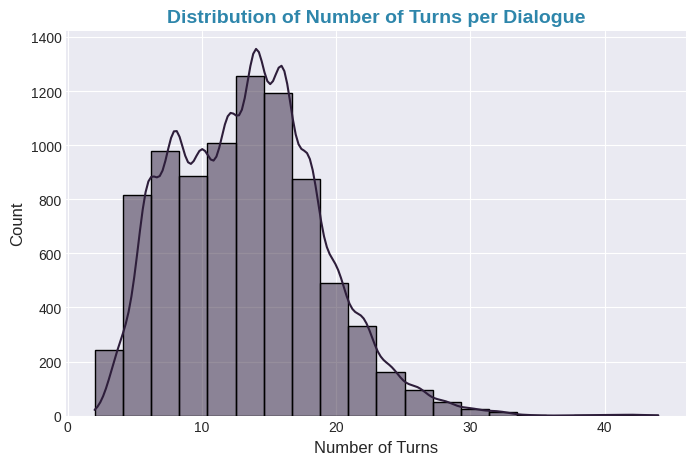

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


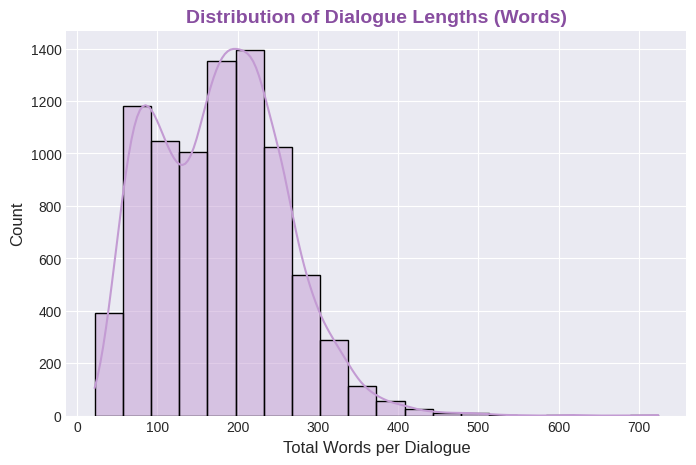

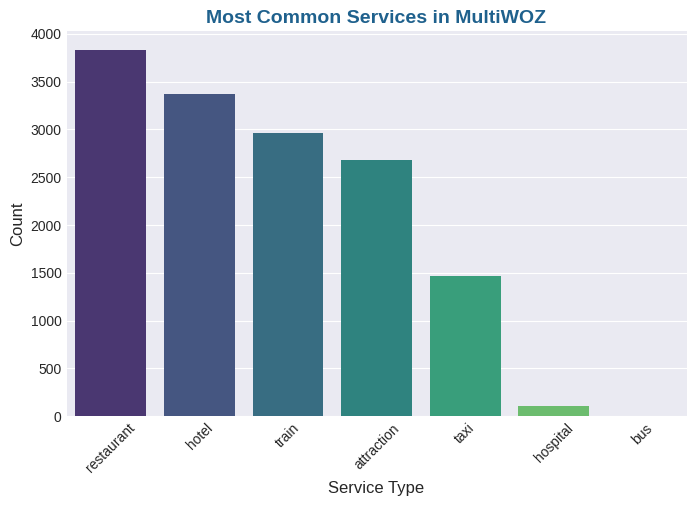

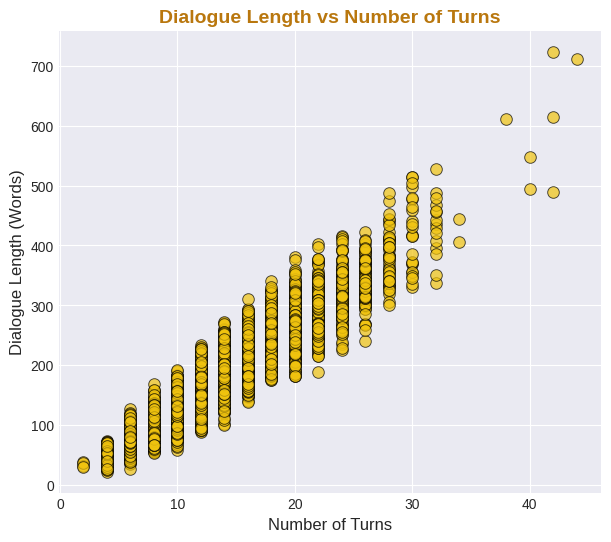


Statistical Summary of MultiWOZ Dialogues

       num_turns  dialogue_length
count    8437.00          8437.00
mean       13.46           177.27
std         5.36            80.72
min         2.00            22.00
25%        10.00           109.00
50%        14.00           179.00
75%        16.00           231.00
max        44.00           724.00

Total Dialogues Analyzed: 8437
Average Number of Turns: 13.45881237406661
Average Dialogue Length (Words): 177.27308284935404

Data Analysis completed successfully!


In [4]:

all_services = []
dialogue_lengths = []
turn_counts = []

for dlg_id, dlg in train_data.items():
    if isinstance(dlg, dict) and 'services' in dlg:
        all_services.extend(dlg['services'])
    if isinstance(dlg, dict) and 'turns' in dlg:
        turn_counts.append(len(dlg['turns']))
        dialogue_texts = [t['utterance'] if 'utterance' in t else "" for t in dlg['turns']]
        dialogue_lengths.append(sum(len(t.split()) for t in dialogue_texts))

df = pd.DataFrame({
    "num_turns": turn_counts,
    "dialogue_length": dialogue_lengths
})

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("mako")

#  Distribution of Number of Turns per Dialogue
plt.figure(figsize=(8,5))
sns.histplot(df["num_turns"], bins=20, kde=True)
plt.title("Distribution of Number of Turns per Dialogue", fontsize=14, fontweight="bold", color="#2E86AB")
plt.xlabel("Number of Turns", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

#  Distribution of Dialogue Lengths (Words)
plt.figure(figsize=(8,5))
sns.histplot(df["dialogue_length"], bins=20, color="#C39BD3", kde=True)
plt.title("Distribution of Dialogue Lengths (Words)", fontsize=14, fontweight="bold", color="#884EA0")
plt.xlabel("Total Words per Dialogue", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

#  Most Common Services in MultiWOZ
service_counts = Counter(all_services)
service_df = pd.DataFrame(service_counts.items(), columns=["Service", "Count"]).sort_values("Count", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=service_df, x="Service", y="Count", palette="viridis")
plt.title("Most Common Services in MultiWOZ", fontsize=14, fontweight="bold", color="#1F618D")
plt.xlabel("Service Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

#  Relationship Between Dialogue Length and Number of Turns
plt.figure(figsize=(7,6))
sns.scatterplot(data=df, x="num_turns", y="dialogue_length", color="#F1C40F", s=70, alpha=0.7, edgecolor="black")
plt.title("Dialogue Length vs Number of Turns", fontsize=14, fontweight="bold", color="#B9770E")
plt.xlabel("Number of Turns", fontsize=12)
plt.ylabel("Dialogue Length (Words)", fontsize=12)
plt.show()

#  Statistical Summary
print("\nStatistical Summary of MultiWOZ Dialogues\n")
print(df.describe().round(2))

print("\nTotal Dialogues Analyzed:", len(df))
print("Average Number of Turns:", df['num_turns'].mean())
print("Average Dialogue Length (Words):", df['dialogue_length'].mean())
print("\nData Analysis completed successfully!")

#  **Training Setup**


In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=500,
    logging_dir="./logs",
    logging_steps=10,
    warmup_steps=100,
    learning_rate=5e-5,
    weight_decay=0.01,
    prediction_loss_only=True
)

optimizer = torch.optim.AdamW(model.parameters(), lr=training_args.learning_rate)

print(" Training setup completed successfully!")
print(f"Using device: {device}")

 Training setup completed successfully!
Using device: cuda


# **Training Loop**


In [6]:

model.train()
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0.0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}")

    for batch_idx, batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(dataloader)
    print(f"\n Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}\n")

print(" Training finished successfully!")

Epoch 1: 100%|██████████| 1552/1552 [12:52<00:00,  2.01it/s, loss=0.5338]



 Epoch 1 completed. Average Loss: 0.5372



Epoch 2: 100%|██████████| 1552/1552 [12:52<00:00,  2.01it/s, loss=0.1411]



 Epoch 2 completed. Average Loss: 0.2642



Epoch 3: 100%|██████████| 1552/1552 [12:52<00:00,  2.01it/s, loss=0.2405]


 Epoch 3 completed. Average Loss: 0.1472

 Training finished successfully!


#  **Proper Response Generation**


In [7]:

def generate_meaningful_response(model, tokenizer, context, device, max_length=100, temperature=0.9):
    model.eval()
    
    if not context.strip().endswith("\nSystem:"):
        prompt = context.strip() + "\nSystem:"
    else:
        prompt = context.strip()
    
    inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)
    
    attention_mask = (inputs != tokenizer.pad_token_id)
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs,
            attention_mask=attention_mask,
            max_length=min(inputs.shape[1] + max_length, 1024),  
            temperature=temperature,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            pad_token_id=tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.pad_token_id,
            no_repeat_ngram_size=2
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    if "System:" in generated_text:
        response = generated_text.split("System:")[-1].strip()
        if "User:" in response:
            response = response.split("User:")[0].strip()
    else:
        response = "I'm not sure how to respond to that."
    
    return response


print(" Response generation function created successfully and cleaned!")

 Response generation function created successfully and cleaned!


# **Test with Better Examples**


In [8]:

print("=== TESTING IMPROVED CHATBOT ===\n")


# Example 1
test_context_1 = """User: I'm looking for a cheap restaurant in the north part of town.
System:"""
response_1 = generate_meaningful_response(model, tokenizer, test_context_1, device)
print(f"Example 1:")
print(f"Context:\n{test_context_1}")
print(f"\nGenerated Response:\n{response_1}")
print("-" * 80)

# Example 2  
test_context_2 = """User: I need to find a hotel in the east.
System: What type of hotel are you looking for?
User: I want a 4-star hotel with free wifi.
System:"""
response_2 = generate_meaningful_response(model, tokenizer, test_context_2, device)
print(f"Example 2:")
print(f"Context:\n{test_context_2}")
print(f"\nGenerated Response:\n{response_2}")
print("-" * 80)

# Example 3
test_context_3 = """User: I'm looking for train information.
System: Where would you like to go?
User: I need to go to Cambridge on Tuesday.
System:"""
response_3 = generate_meaningful_response(model, tokenizer, test_context_3, device)
print(f"Example 3:")
print(f"Context:\n{test_context_3}")
print(f"\nGenerated Response:\n{response_3}")
print("-" * 80)

=== TESTING IMPROVED CHATBOT ===

Example 1:
Context:
User: I'm looking for a cheap restaurant in the north part of town.
System:

Generated Response:
How about Charlie Chan? It is cheap and delicious.
--------------------------------------------------------------------------------
Example 2:
Context:
User: I need to find a hotel in the east.
System: What type of hotel are you looking for?
User: I want a 4-star hotel with free wifi.
System:

Generated Response:
My system is not pulling up any 4 star hotels. Do you want to try a different rating?
--------------------------------------------------------------------------------
Example 3:
Context:
User: I'm looking for train information.
System: Where would you like to go?
User: I need to go to Cambridge on Tuesday.
System:

Generated Response:
There are 13 trains that day. Where are you departing from?
--------------------------------------------------------------------------------
